In [1]:
from qiskit import QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider

In [2]:
import numpy as np
import random
from math import pi
from matplotlib import pyplot as plt

In [3]:
provider = IonQProvider(token="YhJn5ic270pMZQX2xuwt2Zs4S500TmYR")

In [4]:
def make_line (length):
    # determine the number of bits required for at least `length` bit strings
    n = int(np.ceil(np.log(length)/np.log(2)))
    # start with the basic list of bit values
    line = ['0','1']
    # each application of the following process double the length of the list,
    # and of the bit strings it contains
    for j in range(n-1):
        # this is done in each step by first appending a reverse-ordered version of the current list
        line = line + line[::-1]
        # then adding a '0' onto the end of all bit strings in the first half
        for j in range(int(len(line)/2)):
            line[j] += '0'
        # and a '1' onto the end of all bit strings in the second half
        for j in range(int(len(line)/2),int(len(line))):
            line[j] += '1'
    return line

In [5]:
def make_grid(L):
    
    line = make_line( L )
    
    grid = {}
    for x in range(L):
        for y in range(L):
            grid[ line[x]+line[y] ] = (x,y)
    
    return grid

In [6]:
def img2circuit(img, grid):
    
    n = len( list(grid.keys())[0] )
        
    state = [0]*(2**n)
    
    H = 0
    for bitstring in grid:
        h = img[grid[bitstring]] / 256
        state[ int(bitstring,2) ] = np.sqrt(h)
        H += h
        
    for j,amp in enumerate(state):
        state[ j ] = amp/np.sqrt(H)
        
    qc = QuantumCircuit(n,n)
    qc.initialize( state, qc.qregs )
        
    return qc

In [7]:
def circuit2img(L,qc,grid,backend,shots):
    
    # get the number of qubits from the circuit
    n = qc.num_qubits
    
    # construct a circuit to perform z measurements
    for j in range(n):
        qc.measure(j,j)

    #run the circuit on the supplied backend
    counts = execute(qc,backend,shots=shots).result().get_counts() 
    
    max_h = np.log( max( counts.values() ) )
    
    # loop over all bit strings in `counts`, and set the corresponding count to be
    # the value for the corresponding coordinate. Values are rescaled to ensure
    # that the largest is 1, and that none is less than zero.
    img = np.zeros((L, L), dtype=np.uint8)
    for bitstring in counts:
        if bitstring in grid:
            if counts[bitstring] > 0:
                img[ grid[bitstring] ] = np.log(counts[bitstring]+1) * 256 / max_h
    
    return img

In [8]:
def generate_seed(L,num=5):
    # generate a noise map of `num` randomly chosen points, each with randomly chosen values
    image = np.zeros((L, L), dtype=np.uint8)
    
    for _ in range(num - 1):
        x = random.randint(0,L-1)
        y = random.randint(0,L-1)
        image[x,y] = random.random() * 256
    
    x = random.randint(0,L-1)
    y = random.randint(0,L-1)
    image[x,y] = 255
        
    return image

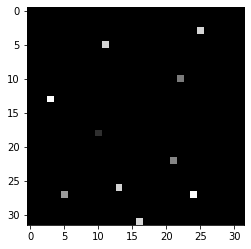

In [22]:
L = 32
grid = make_grid(L)
seed = generate_seed(L, 10)
plt.imshow(seed, cmap = 'gray')

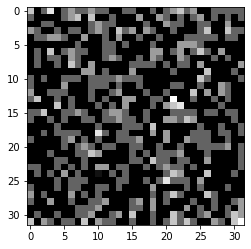

In [23]:
qc = img2circuit(seed,grid)
qc.ry(pi/6,qc.qregs[0])
qc.rx(pi/6,qc.qregs[0])
sq = circuit2img(L,qc,grid,provider.get_backend("ionq_qpu"),shots=640)
plt.imshow(sq, cmap='gray')

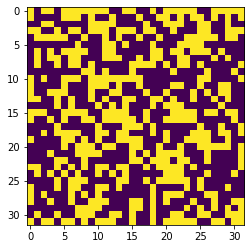

In [24]:
plt.imshow([[1 if x > 0 else -1 for x in arr] for arr in sq])

In [25]:
def shuffle_img (img,grid):
    
    # determine the number of qubits
    n = int( np.log(len(grid))/np.log(2) )
    
    # randomly choose a way to shuffle the bit values in the string
    shuffle = [j for j in range(n)]
    random.shuffle(shuffle)
    
    # for each bit string, determine and record the pair of positions
    # * `pos`: the position correspoding to the bit string in the given `grid`
    # * `new_pos`: the position corresponding to the shuffled version of the bit string
    remap = {}
    for bitstring in grid:
        
        shuffledstring = ''.join([bitstring[j] for j in shuffle])

        pos = grid[bitstring]
        new_pos = grid[shuffledstring]
        
        remap[pos] = new_pos
        
        
    # create and return `new_img`, in which each point is moved from `pos` to `new_pos`
    new_img = np.zeros((L, L), dtype=np.uint8)
    for (x, arr) in enumerate(img):
        for (y, val) in enumerate(arr):
            new_img[remap[x,y]] = img[x,y]
        
    return new_img

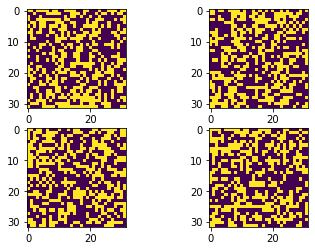

In [26]:
def simplify_shuffle(img, grid):
    return [[1 if x > 0 else -1 for x in arr] for arr in shuffle_img(img, grid)]

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(simplify_shuffle(sq, grid))
axs[0,1].imshow(simplify_shuffle(sq, grid))
axs[1,0].imshow(simplify_shuffle(sq, grid))
axs[1,1].imshow(simplify_shuffle(sq, grid))

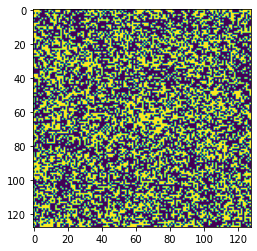

In [64]:
size = 128
frames = 128
iterations_per_frame = 4000

Lattice = np.zeros((size, size), dtype=int)

for x in range(size//L):
    for y in range(size//L):
            new_img = simplify_shuffle(sq, grid)
            for x2 in range(L):
                for y2 in range(L):
                    Lattice[x*L+x2,y*L+y2] = new_img[x2][y2]

plt.imshow(Lattice)

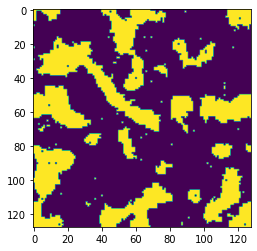

In [65]:
fig = plt.figure()

def update(i):
    for _ in range(iterations_per_frame):
        x, y = random.randint(0,size-1), random.randint(0,size-1)
        
        C = Lattice[y,x]
        N = Lattice[(y-1)%size,x]
        E = Lattice[y,(x+1)%size]
        S = Lattice[(y+1)%size,x]
        W = Lattice[y,(x-1)%size]

        H = int(C==N) + int(C==E) + int(C==S) + int(C==W) # low H corresponds to high energy
        if H < 1:
            Lattice[y,x] *= -1
        elif random.uniform(0,1) < 2**(-4*(H-2)):
            Lattice[y,x] *= -1

for i in range(1,frames):
    update(i)

plt.imshow(Lattice)

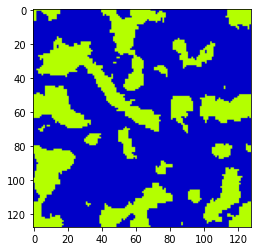

In [66]:
Image = [[(0,0,0) for x in range(size)] for y in range(size)]


# delete lone pixels
for x in range(size):
    for y in range(size):
        C = Lattice[y][x]
        N = Lattice[(y-1)%size][x]
        E = Lattice[y][(x+1)%size]
        S = Lattice[(y+1)%size][x]
        W = Lattice[y][(x-1)%size]

        H = (C==N) + (C==E) + (C==S) + (C==W)

        if H < 1: Lattice[y][x] *= -1

        if Lattice[y][x] == 1:
            Image[y][x] = (180,255,0)
        else:
            Image[y][x] = (0,0,200)

plt.imshow(Image)
fileName = 'map.jpg'
plt.savefig(fileName)